<a href="https://colab.research.google.com/github/Timmmtech/Pytorch-Basics/blob/main/Project2_Feedforward_Neuralnetwork.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torchvision
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
from torchvision.datasets import CIFAR10
from torchvision.transforms import ToTensor
from torchvision.utils import make_grid
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import random_split
%matplotlib inline
# Use a white background for matplotlib figures
matplotlib.rcParams['figure.facecolor'] = '#ffffff'

## Download & Explore the Dataset

In [2]:
dataset = CIFAR10(root='data/', download=True, transform=ToTensor())
test_dataset = CIFAR10(root='data/', train=False, transform=ToTensor())


100%|██████████| 170M/170M [00:03<00:00, 44.9MB/s]


### Q: How many images does the training dataset contain?

In [3]:
dataset_size = len(dataset)
dataset_size

50000

### Q: How many images does the testing dataset contain?

In [4]:
test_dataset_size = len(test_dataset)
test_dataset_size

10000

### Q: How many output classes does the dataset contain?


In [5]:
classes = dataset.classes
classes

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

In [6]:
num_classes = len(classes)
num_classes

10

### Q: What is the shape of an image tensor from the dataset?

In [7]:
img, label = dataset[0]
img_shape = img.shape
img_shape

torch.Size([3, 32, 32])

Label (numeric): 4
Label (textual): deer


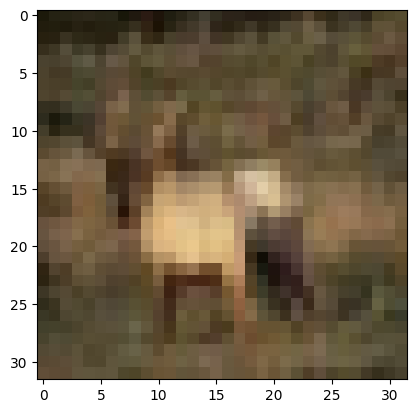

In [8]:
img, label = dataset[3]
plt.imshow(img.permute((1, 2, 0)))
print('Label (numeric):', label)
print('Label (textual):', classes[label])

###

### Q: Determine the number of images belonging to each class?

In [9]:
number = {}
for img,label in dataset:
    number[classes[label]] = number.get(classes[label], 0) + 1
number

{'frog': 5000,
 'truck': 5000,
 'deer': 5000,
 'automobile': 5000,
 'bird': 5000,
 'horse': 5000,
 'ship': 5000,
 'cat': 5000,
 'dog': 5000,
 'airplane': 5000}

## Preparing the data for training
We'll use a validation set with 5000 images (10% of the dataset). To ensure we get the same validation set each time, we'll set PyTorch's random number generator to a seed value of 43.

In [10]:
torch.manual_seed(43)
val_size = 5000
train_size = len(dataset) - val_size

In [11]:
## Define training & validation sets
train_ds, val_ds = random_split(dataset, [train_size, val_size])
len(train_ds), len(val_ds)

(45000, 5000)

In [12]:
## Create data loaders to load the data in batches
batch_size = 128

In [13]:
train_loader = DataLoader(train_ds, batch_size, shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_ds, batch_size*2, num_workers=4, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size*2, num_workers=4, pin_memory=True)

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:424: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  self.check_worker_number_rationality()


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:432: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  self.check_worker_number_rationality()


images.shape: torch.Size([128, 3, 32, 32])


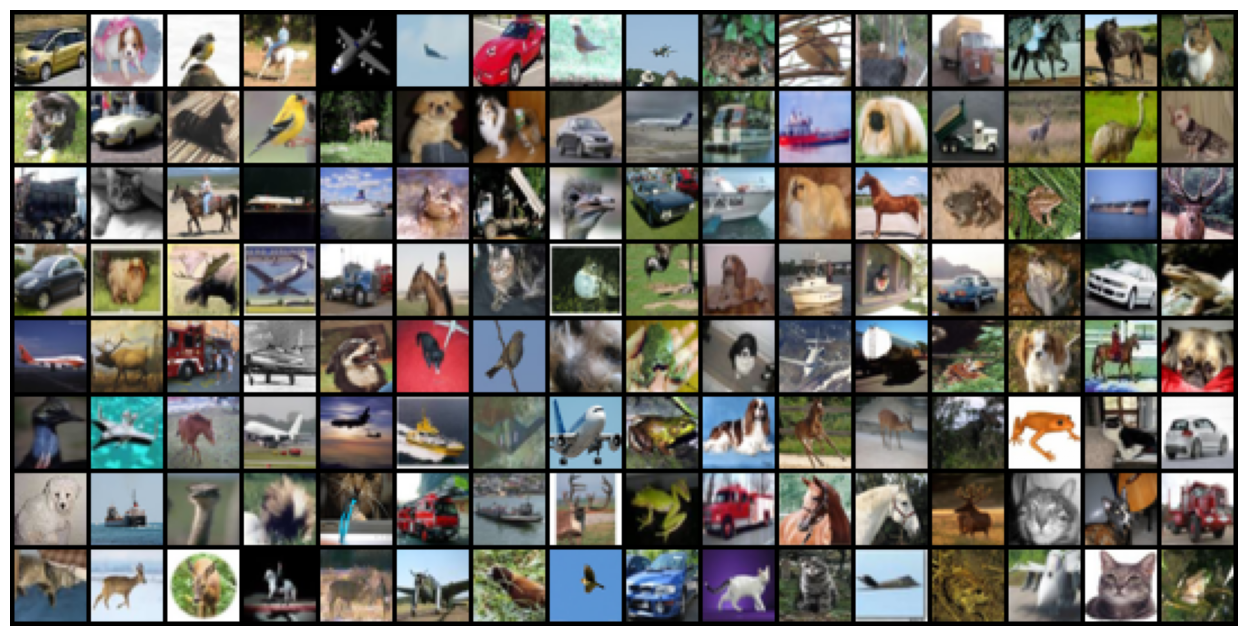

In [14]:
## Visualize a batch of data
for images, _ in train_loader:
    print('images.shape:', images.shape)
    plt.figure(figsize=(16,8))
    plt.axis('off')
    plt.imshow(make_grid(images, nrow=16).permute((1, 2, 0)))
    break

## Base Model class & Training on GPU
Let's create a base model class, which contains everything except the model architecture i.e. it wil not contain the __init__ and __forward__ methods. We will later extend this class to try out different architectures. In fact, you can extend this model to solve any image classification problem.

In [15]:
## Define the accuracy function
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [16]:
class ImageClassificationBase(nn.Module):

  def training_step(self, batch):
    """Returns a loss for a batch of Training data"""
    images, labels = batch
    out = self(images)  # Generate predictions
    loss = F.cross_entropy(out, labels) # Calculate loss
    return loss

  def validation_step(self, batch):
    """Calculates loss and accuracy for a batch of validation data"""
    images, labels = batch
    out = self(images)  # Generate predictions
    loss = F.cross_entropy(out, labels)  # Calculate loss
    acc = accuracy(out, labels)  # Calculate accuracy
    return {'val_loss': loss.detach(), 'val_acc': acc}

  def validation_epoch_end(self, outputs):
    """Calculates average validation loss and accuracy across the epoch"""
    batch_losses = [x['val_loss'] for x in outputs]
    epoch_loss = torch.stack(batch_losses).mean()  # Combine losses
    batch_accs = [x['val_acc'] for x in outputs]
    epoch_acc = torch.stack(batch_accs).mean()  # Combine accuracies
    return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}

  def epoch_end(self, epoch, result):
    print(
        f"Epoch [{epoch}], "
        f"val_loss: {result['val_loss']:.4f}, "
        f"val_acc: {result['val_acc']:.4f}"
    )

In [17]:
def evaluate(model, val_loader):
  """Evaluate the model's performance on the validation set"""
  model.eval()  # Switch to evaluation mode

  outputs = []
  with torch.no_grad():    # Disable gradient tracking
    for batch in val_loader:
      outputs.append(model.validation_step(batch))

  return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
  """Trains the model using gradient descent"""
  history = []
  optimizer = opt_func(model.parameters(), lr)
  for epoch in range(epochs):
    # Training Phase
    model.train()  # Switch to training mode
    train_losses = [] # Initialize list to store training losses
    for batch in train_loader:
      loss = model.training_step(batch)
      train_losses.append(loss.item()) # Store training loss
      loss.backward()
      optimizer.step()
      optimizer.zero_grad()
    # Validation phase
    result = evaluate(model, val_loader)
    epoch_train_loss = torch.tensor(train_losses).mean().item() # Calculate average training loss
    result['loss'] = epoch_train_loss # Add training loss to result dictionary
    model.epoch_end(epoch, result)
    history.append(result)
  return history

In [18]:
## Set pipelines to move code to GPU
torch.cuda.is_available()

True

In [19]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
       return torch.device('cuda')
    else:
        return torch.device('cpu')

In [20]:
device = get_default_device()
device

device(type='cuda')

In [21]:
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device

    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl:
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [22]:
## Define Helper function to plot loss and accuracies
def plot_losses(history):
    plt.figure(figsize=(6, 5))
    train_losses = [r['loss'] for r in history]
    val_losses = [r['val_loss'] for r in history]
    plt.plot(train_losses, c='k', label="train_loss")
    plt.plot(val_losses, c='r', label="val_loss")
    plt.legend()
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.title('Loss vs. epochs')

In [23]:
def plot_accuracies(history):
    plt.figure(figsize=(6, 5))
    train_acc = [r['acc'] for r in history]
    val_acc = [r['val_acc'] for r in history]
    plt.plot(train_acc, c='k', label="train_acc")
    plt.plot(val_acc, c='r', label="val_acc")
    plt.legend()
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. epochs')

In [24]:
## Move data loaders to appropriate device
train_loader = DeviceDataLoader(train_loader, device)
val_loader = DeviceDataLoader(val_loader, device)
test_loader = DeviceDataLoader(test_loader, device)

## Training the Model

In [25]:
input_size = 3*32*32
output_size = 10

### Q: Extend the ImageClassificationBase class to complete the model definition.

In [26]:
class CIFAR10Model(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        self.linear_1 = nn.Linear(input_size, 2048)
        self.linear_2 = nn.Linear(2048, 512)
        self.linear_3 = nn.Linear(512, 64)
        self.linear_4 = nn.Linear(64, output_size)

    def forward(self, xb):
        # Flatten images into vectors
        out = xb.view(xb.size(0), -1)
        # Apply layers & activation functions
        out = self.linear_1(out)
        out = F.relu(out)

        out = self.linear_2(out)
        out = F.relu(out)

        out = self.linear_3(out)
        out = F.relu(out)

        out = self.linear_4(out)
        return out

In [27]:
## Move the model to appropriate device
model = to_device(CIFAR10Model(), device)

In [28]:
## Try it out on validation ste to get initial loss & acc
history = [evaluate(model, val_loader)]
history

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:432: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  self.check_worker_number_rationality()


[{'val_loss': 2.3047003746032715, 'val_acc': 0.09933363646268845}]

### Q: Train the model using the fit function to reduce the validation loss & improve accuracy.

In [29]:
history = fit(20, 0.08, model, train_loader, val_loader)

Epoch [0], val_loss: 1.8772, val_acc: 0.3275
Epoch [1], val_loss: 1.9035, val_acc: 0.3147
Epoch [2], val_loss: 1.7005, val_acc: 0.3901
Epoch [3], val_loss: 1.7115, val_acc: 0.3771
Epoch [4], val_loss: 1.5675, val_acc: 0.4475
Epoch [5], val_loss: 1.6004, val_acc: 0.4330
Epoch [6], val_loss: 1.6170, val_acc: 0.4212
Epoch [7], val_loss: 1.5111, val_acc: 0.4621
Epoch [8], val_loss: 1.5404, val_acc: 0.4512
Epoch [9], val_loss: 1.5530, val_acc: 0.4431
Epoch [10], val_loss: 1.5424, val_acc: 0.4477
Epoch [11], val_loss: 1.5775, val_acc: 0.4391
Epoch [12], val_loss: 1.5171, val_acc: 0.4623
Epoch [13], val_loss: 1.6093, val_acc: 0.4409
Epoch [14], val_loss: 1.4389, val_acc: 0.4857
Epoch [15], val_loss: 1.4041, val_acc: 0.5046
Epoch [16], val_loss: 1.5122, val_acc: 0.4635
Epoch [17], val_loss: 1.4856, val_acc: 0.4897
Epoch [18], val_loss: 1.4662, val_acc: 0.4802
Epoch [19], val_loss: 1.4019, val_acc: 0.5147


In [30]:
history += fit(20, 0.01, model, train_loader, val_loader)

Epoch [0], val_loss: 1.3085, val_acc: 0.5465
Epoch [1], val_loss: 1.3101, val_acc: 0.5413
Epoch [2], val_loss: 1.3100, val_acc: 0.5473
Epoch [3], val_loss: 1.3087, val_acc: 0.5550
Epoch [4], val_loss: 1.3020, val_acc: 0.5519
Epoch [5], val_loss: 1.3059, val_acc: 0.5505
Epoch [6], val_loss: 1.3036, val_acc: 0.5484
Epoch [7], val_loss: 1.3063, val_acc: 0.5532
Epoch [8], val_loss: 1.3036, val_acc: 0.5530
Epoch [9], val_loss: 1.3225, val_acc: 0.5478
Epoch [10], val_loss: 1.3197, val_acc: 0.5477
Epoch [11], val_loss: 1.3190, val_acc: 0.5522
Epoch [12], val_loss: 1.3278, val_acc: 0.5496
Epoch [13], val_loss: 1.3164, val_acc: 0.5539
Epoch [14], val_loss: 1.3381, val_acc: 0.5427
Epoch [15], val_loss: 1.3292, val_acc: 0.5518
Epoch [16], val_loss: 1.3330, val_acc: 0.5551
Epoch [17], val_loss: 1.3315, val_acc: 0.5494
Epoch [18], val_loss: 1.3424, val_acc: 0.5556
Epoch [19], val_loss: 1.3602, val_acc: 0.5553


In [31]:
history += fit(20, 2e-3, model, train_loader, val_loader)

Epoch [0], val_loss: 1.3282, val_acc: 0.5588
Epoch [1], val_loss: 1.3295, val_acc: 0.5567
Epoch [2], val_loss: 1.3312, val_acc: 0.5575
Epoch [3], val_loss: 1.3301, val_acc: 0.5563
Epoch [4], val_loss: 1.3298, val_acc: 0.5573
Epoch [5], val_loss: 1.3328, val_acc: 0.5571
Epoch [6], val_loss: 1.3324, val_acc: 0.5602
Epoch [7], val_loss: 1.3363, val_acc: 0.5591
Epoch [8], val_loss: 1.3359, val_acc: 0.5594
Epoch [9], val_loss: 1.3404, val_acc: 0.5578
Epoch [10], val_loss: 1.3368, val_acc: 0.5612
Epoch [11], val_loss: 1.3390, val_acc: 0.5610
Epoch [12], val_loss: 1.3395, val_acc: 0.5581
Epoch [13], val_loss: 1.3417, val_acc: 0.5606
Epoch [14], val_loss: 1.3484, val_acc: 0.5617
Epoch [15], val_loss: 1.3439, val_acc: 0.5598
Epoch [16], val_loss: 1.3486, val_acc: 0.5577
Epoch [17], val_loss: 1.3512, val_acc: 0.5626
Epoch [18], val_loss: 1.3544, val_acc: 0.5551
Epoch [19], val_loss: 1.3526, val_acc: 0.5608


In [32]:
history += fit(20, 3e-4, model, train_loader, val_loader)

Epoch [0], val_loss: 1.3481, val_acc: 0.5594
Epoch [1], val_loss: 1.3486, val_acc: 0.5612
Epoch [2], val_loss: 1.3498, val_acc: 0.5592
Epoch [3], val_loss: 1.3494, val_acc: 0.5590
Epoch [4], val_loss: 1.3491, val_acc: 0.5616
Epoch [5], val_loss: 1.3491, val_acc: 0.5612
Epoch [6], val_loss: 1.3497, val_acc: 0.5606
Epoch [7], val_loss: 1.3500, val_acc: 0.5614
Epoch [8], val_loss: 1.3502, val_acc: 0.5616
Epoch [9], val_loss: 1.3503, val_acc: 0.5594
Epoch [10], val_loss: 1.3511, val_acc: 0.5596
Epoch [11], val_loss: 1.3503, val_acc: 0.5600
Epoch [12], val_loss: 1.3509, val_acc: 0.5606
Epoch [13], val_loss: 1.3516, val_acc: 0.5614
Epoch [14], val_loss: 1.3516, val_acc: 0.5588
Epoch [15], val_loss: 1.3527, val_acc: 0.5616
Epoch [16], val_loss: 1.3520, val_acc: 0.5604
Epoch [17], val_loss: 1.3529, val_acc: 0.5606
Epoch [18], val_loss: 1.3523, val_acc: 0.5614
Epoch [19], val_loss: 1.3521, val_acc: 0.5598
